
# Use Case: Using land cover products to monitor Land Cover (LC) changes.
 
## User Question: How well do satellite observations capture land cover changes, such as urbanization?


### About
In this Use Case we will access the ***Land cover classification gridded maps from 1992 to present derived from satellite observations*** (henceforth, LC) data from the Climate Data Store (CDS) of the Copernicus Climate Change Service (C3S), and analyse the spatial patterns of the LC reliability over a given Area of Interest (AoI).


**This Notebook comprises the following steps:**

1. Define the AoI, search and download LC data.
2. Inspect and view data for the defined AoI (Iberian Peninsula).
3. Calculate total area and area percentage of change for the AoI by LC classes. 
4. Calculate the area percentage for the most populated regions (NUTS2).
5. Main Takeaways.

**The main takeaways of this Use Case are:**

* The dataset has been demonstrated as consistent with equivalent statistics from official sources that could provide confirmation. In particular, in our analysis, we observed that the "Urban/Settlements" category closely aligned with EUROSTAT's statistics for the 2018 (https://ec.europa.eu/eurostat/databrowser/explore/all/all_themes) "Artificial Land" and "Wetland" categories in the most populated NUTs 2 regions (with only a very small 5 to 8% percentage difference).

* Nonetheless, discrepancies were identified in the "Grassland" and "Agriculture/Cropland" categories. These differences are attributable to the varying methodologies employed to classify and aggregate land cover categories across the two datasets. For example, while the Land Cover dataset incorporates greenhouses within the Agriculture IPCC class, EUROSTAT classifies them as Artificial Land. This variation highlights the critical need to understand classification schemes when comparing datasets.

* Different spatial patterns can be observed accross NUTS 2. Between 1992 and 2020 an increase of more than 100% can be observed the in 'Urban' LC class, especially in regions that include larger metropolitan cities, such as 'Comunidad de Madrid', Spain, or 'Área Metropolitana de Lisboa', Portugal.

* Together, Forest, Grassland and Agricultural classes have the highest expression in our AoI (versus Settlement); however, the Settlement's area increase seems to be compensated mostly by equivalente Agriculture and Grassland area loss, whereas no significant changes are noted in Forest.

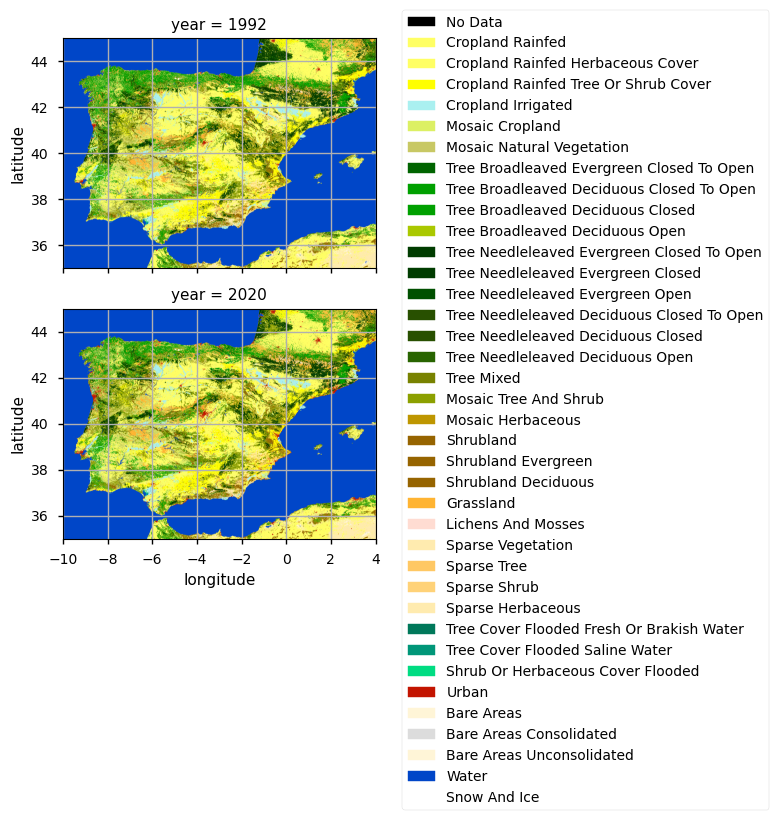

## Define the AoI, search and download LC data.
Before we begin we must prepare our environment. This includes installing the Application Programming Interface (API) of the CDS, and importing the various python libraries that we will need.

### Install CDS API
To install the CDS API, run the following command. We use an exclamation mark to pass the command to the shell (not to the Python interpreter).
If you already have the CDS API installed, you can skip or comment this step.

In [1]:
!pip install cdsapi

### Import all the libraries/packages

We will be working with data in NetCDF format. To best handle this type of data we will use libraries for working with multidimensional arrays, in particular Xarray. 
We will also need libraries for plotting and viewing data.

In [2]:
import geopandas as gpd # import vector geospatial data
import matplotlib.pyplot as plt # plot graphs
import numpy as np # perform trigonometric calculations
import shapely.geometry # work with geometric shapes
import regionmask # transform attributes and geometries into specific regions
import xarray as xr
from c3s_eqc_automatic_quality_control import download, plot, utils 

plt.style.use("seaborn-v0_8-notebook") # predifined style of all graphical outputs

### Data Overview

To search for data, visit the CDS website: http://cds.climate.copernicus.eu. Here you can search for 'Satellite observations' using the search bar. The data we need for this tutorial is the ***Land cover classification gridded maps from 1992 to present derived from satellite observations***. This catalogue entry provides global Land Cover Classification (LCC) maps with a very high spatial resolution, with a L4 processing level, on an annual basis with a one-year delay, following the Global Climate Observing System (GCOS) convention. LULC maps correspond to a global classification scheme, encompassing 22 classes. For intercomparison consistency, <ins>LC classes are grouped into the six IPCC land categories:</ins> **cropland, forest, grassland, wetland, settlement, and other land (shrubland, sparse vegetation, bare area and water)**, as gathered from several international sources.

The dataset consists of 2 versions (v2.0.7 produced by the European Space Agency (ESA) Climate Change Initiative (CCI) and v2.1.1 produced by Copernicus Climate Change Service (C3S)).

Data specifications for this use case:
* **Year:** 1992 and 2020
* **Version:** v2.0.7 for 1992 and v2.1.1 for 2020
* **Format:** Zip files

At the end of the download form, select “**Show API request**”. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook …

Download data
… having copied the API request to a Jupyter Notebook cell, running it will retrieve and download the data you requested into your local directory. However, before you run it, the **terms and conditions** of this particular dataset need to have been accepted directly at the CDS website. The option to view and accept these conditions is given at the end of the download form, just above the “**Show API request**” option. In addition, it is also useful to define the time period and AoI parameters and edit the request accordingly, as exemplified in the cells below.

In [3]:
#Years to download
years = [1992, 2020]

# Region of interest (Iberian Peninsula)
lon_slice = slice(-10, 4)
lat_slice = slice(45, 35)

# Shapefile with regions (NUTS2)
shapefile_url = "https://gisco-services.ec.europa.eu/distribution/v2/nuts/shp/NUTS_RG_20M_2021_4326.shp.zip" #NUTS2 download path

In [4]:
# List of requests to retrieve data
collection_id = "satellite-land-cover"
requests = [
    {
        "variable": "all",
        "format": "zip",
        "version": "v2.0.7cds" if year < 2016 else "v2.1.1",
        "year": year,
    }
    for year in years
]

In [5]:
# Download and regionalize by AoI
ds = download.download_and_transform(
    collection_id,
    requests,
    transform_func=utils.regionalise,
    transform_func_kwargs={"lon_slice": lon_slice, "lat_slice": lat_slice},
)
ds = ds.assign_coords(year=ds["time"].dt.year).swap_dims(time="year").drop("time")

100%|██████████| 2/2 [00:01<00:00,  1.77it/s]


## Inspect and view data

Now that we have downloaded the data, we can inspect it. We have requested the data in NetCDF format. This is a commonly used format for array-oriented scientific data. To read and process this data we will make use of the Xarray library. Xarray is an open source project and Python package that makes working with labelled multi-dimensional arrays simple and efficient. We will read the data from our NetCDF file into an xarray

### Label Color Definition and Class Correspondence

To facilitate visual inspection of the LC classes, we will define a dictionary containing each class label ('keys', below) and the corresponding color ('colors', below) and numeric flag ('values), below. In additon, we will also create a second dictionary to define the correspondence between the original classes of our metadata and the IPCC classes, as described in the Product User Guide (see References).

In [6]:
# Define LC labels dictionary
keys = ds.lccs_class.flag_meanings.split()
colors = ds.lccs_class.flag_colors.split()
element = "#000000"
colors.insert(0, element)
values = ds.lccs_class.flag_values

lccs_dict = {key: (color, value) for key, color, value in zip(keys, colors, values)}

# Helper function to format the labels text
def format_key(key):
    return key.replace("_", " ").title()

lccs_dict = {format_key(key): value for key, value in lccs_dict.items()}
lccs_dict

{'No Data': ('#000000', 0),
 'Cropland Rainfed': ('#ffff64', 10),
 'Cropland Rainfed Herbaceous Cover': ('#ffff64', 11),
 'Cropland Rainfed Tree Or Shrub Cover': ('#ffff00', 12),
 'Cropland Irrigated': ('#aaf0f0', 20),
 'Mosaic Cropland': ('#dcf064', 30),
 'Mosaic Natural Vegetation': ('#c8c864', 40),
 'Tree Broadleaved Evergreen Closed To Open': ('#006400', 50),
 'Tree Broadleaved Deciduous Closed To Open': ('#00a000', 60),
 'Tree Broadleaved Deciduous Closed': ('#00a000', 61),
 'Tree Broadleaved Deciduous Open': ('#aac800', 62),
 'Tree Needleleaved Evergreen Closed To Open': ('#003c00', 70),
 'Tree Needleleaved Evergreen Closed': ('#003c00', 71),
 'Tree Needleleaved Evergreen Open': ('#005000', 72),
 'Tree Needleleaved Deciduous Closed To Open': ('#285000', 80),
 'Tree Needleleaved Deciduous Closed': ('#285000', 81),
 'Tree Needleleaved Deciduous Open': ('#286400', 82),
 'Tree Mixed': ('#788200', 90),
 'Mosaic Tree And Shrub': ('#8ca000', 100),
 'Mosaic Herbaceous': ('#be9600', 110),

In [7]:
# Define IPCC labels dictionary
ipcc_dict = {
    "No Data": ("#000000", [0]),
    "Agriculture": ("#ffffcc", [10, 11, 12, 20, 30, 40]),
    "Forest": ("#4c9900", [50, 60, 61, 62, 70, 71, 72, 80, 81, 82, 90, 100, 160, 170]),
    "Grassland": ("#ccff99", [110, 130]),
    "Settlement": ("#ff0000", [190]),
    "Wetland": ("#99ffff", [180]),
    "Other": ("#0000ff", [120, 121, 122, 140, 150, 151, 152, 153, 200, 201, 202, 210]),
}

ipcc_dict 

{'No Data': ('#000000', [0]),
 'Agriculture': ('#ffffcc', [10, 11, 12, 20, 30, 40]),
 'Forest': ('#4c9900',
  [50, 60, 61, 62, 70, 71, 72, 80, 81, 82, 90, 100, 160, 170]),
 'Grassland': ('#ccff99', [110, 130]),
 'Settlement': ('#ff0000', [190]),
 'Wetland': ('#99ffff', [180]),
 'Other': ('#0000ff',
  [120, 121, 122, 140, 150, 151, 152, 153, 200, 201, 202, 210])}

### Plot maps

Having defined the color and legends for the IPCC classes and using the metadata of the dataset to get the colors and legends for each Land Cover class it is now possible to plot our data either with the original colors or with the IPCC previously defined colors.

The function below plots the year 1992 and the year 2020 LC maps, using both land cover schemes. From the output, we can already distinguish some changes at the location of the larger metropolitan areas of the Iberian Peninsula.

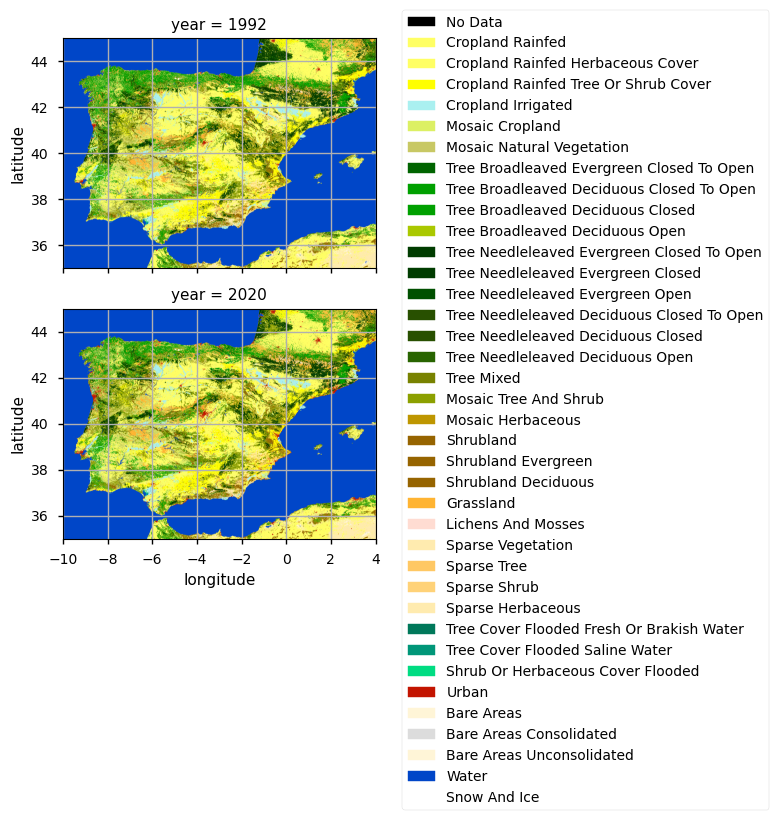

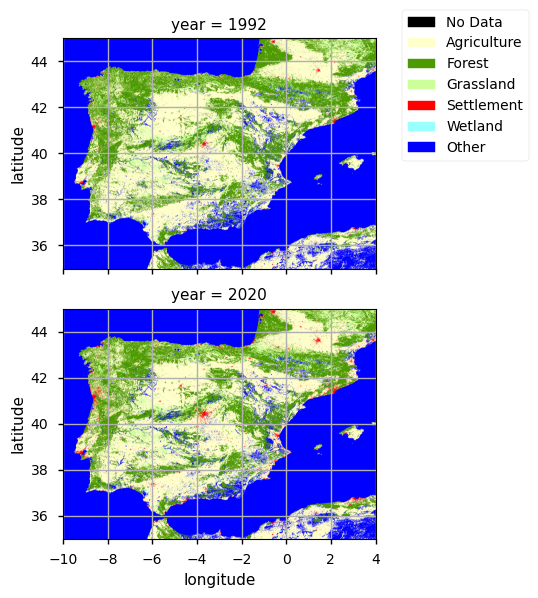

In [8]:
# Plot AoI LC in both years for both land cover schemes
for legend_dict in [None, ipcc_dict]:
    plot.lccs_map(
        ds["lccs_class"],
        row="year",
        legend_dict=legend_dict,
        interpolation="antialiased",
    )
    plt.show()

## Calculate total area and area percentage of change in for AoI by LC classes

To further identify changes in LC patterns, in this user question, NUTS 2 will be used, providing the information reggarding the main regions/parcels of the Iberian Peninsula.

The NUTS are a hierarchical system divided into 3 levels (https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts). NUTS 1 correspond to major socio-economic regions, NUTS 2 correspond to basic regions for the application of regional policies, and NUTS 3 correpsond to small regions for specific diagnoses. Additionally a NUTS 0 level, usually co-incident with national boundaries is also available. The NUTS legislation is periodically amended; therefore multiple years are available for download. 


The step below masks the Land Cover data according to the NUTS 2 boundaries and calculate the area of each pixel (weighted by Latitude). For each NUTS 2, we proceed with the analysis and visual inspection of Land Cover areas per class and corresponding percentages during the elected period.

### Mask regions

First, we need to establish the geometry of the NUTS region (level 2) in order to make the corresponding statistics.

In [9]:
# Define longitude and latitude bounds for the region of interest
lon_bounds = [-10.18, 1]
lat_bounds = [36.5, 43]
crs = "epsg:4326" #coordinate system

lon_bounds += sorted(lon_bounds, reverse=True)
lat_bounds = [lat for lat in lat_bounds for _ in range(2)]

bbox = shapely.Polygon(zip(lon_bounds, lat_bounds)) # create a bounding box polygon using Shapely

# Data filter
gdf = gpd.read_file(shapefile_url) # read the shapefile NUTS2
gdf = gdf[gdf["LEVL_CODE"] == 2] # keep only features at the second administrative level (LEVL_CODE == 2)
gdf = gdf[gdf.intersects(bbox)] # keep only features that intersect with the defined bounding box
gdf = gdf[gdf["NUTS_ID"].str.startswith(("ES", "PT"))] # keep only features with NUTS_ID starting with "ES" or "PT"
gdf = gdf.to_crs(crs)

ds.rio.write_crs(crs, inplace=True)

regions = regionmask.from_geopandas(gdf, names="NUTS_NAME") # create regions based on the filtered GeoPandas DataFrame
mask = regions.mask(ds["longitude"], ds["latitude"]) # create a mask based on the regions and the xarray dataset's coordinates

### Compute cell area

Then, we can calculate the area of each pixel taking into consideration the curvature of the earth (i.e., weighted by Latitude).

In [10]:
# Calculate Pixel Area
scaling_factor = 0.002778 # define a scaling factor for conversion
resolution_km = scaling_factor * 111.195 # calculate the grid cell resolution in kilometers
indexes = xr.DataArray(range(ds.sizes["latitude"]), dims="latitude") # create an array of indexes representing latitude positions
lats = ds["latitude"].max() - indexes * scaling_factor
grid_cell_area = resolution_km**2 * np.cos(np.radians(lats))
grid_cell_area.attrs = {
    "standard_name": "cell_area",
    "long_name": "Area",
    "units": "km2",
}
ds = ds.assign_coords(cell_area=grid_cell_area)

### Bar Charts - Iberian Peninsula

Having the area calculated and the NUTS 2 regions assigned to each pixel, we can now proceed to create the plots of the LC areas per class, by year. First, let's inspect the total area of each LC class in this AoI. We will use the original LC classes to highlighted which ones have more significant changes.

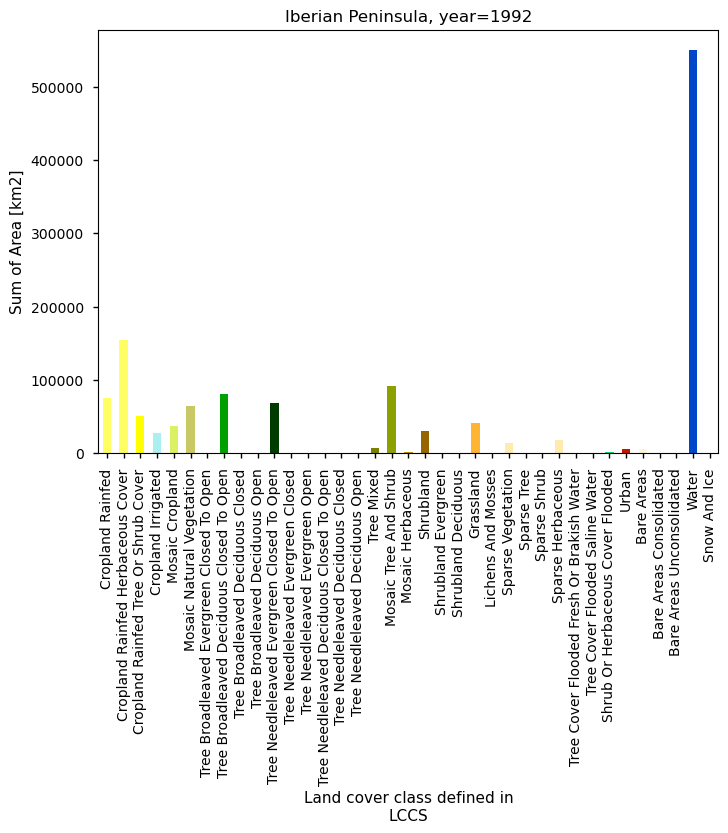

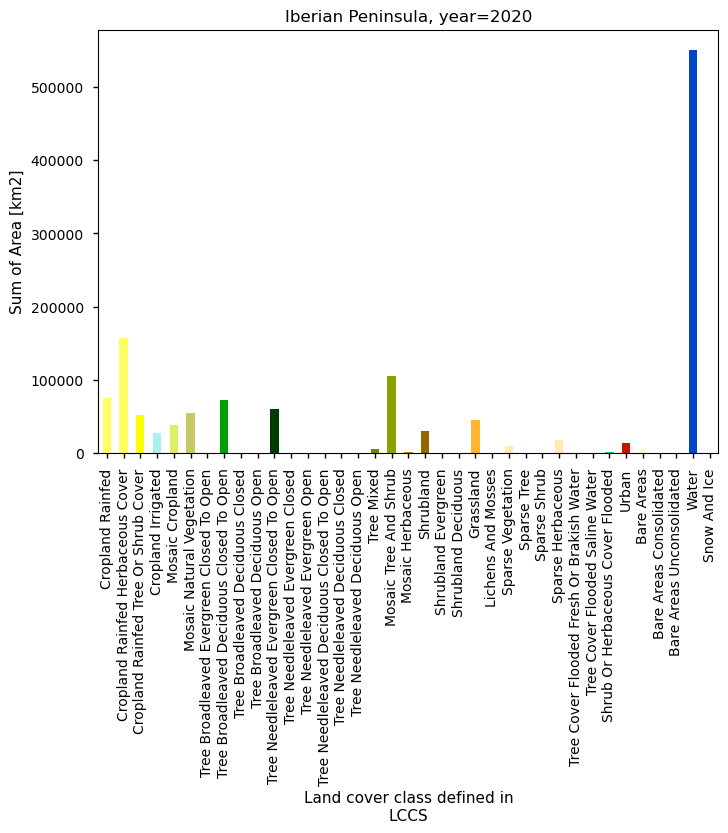

In [11]:
#Plot the distribution of LC classes in the AoI over different years. 
area = ds["cell_area"]

for labels_dict in [None]:
    for year, ds_year in ds.groupby("year"):
        # First loop for "area" data
        plot.lccs_bar(
            area,
            ds_year["lccs_class"],
            labels_dict,
            reduction="sum",
            title=f"Iberian Peninsula, {year=}",
        )
        plt.show()

From these plots, the 'Urban' class seems to show the largest change between 1992 and 2020, despite being the second class with the lowest total area. In addition, the 'Water' class has the greatest area in this AoI - this is expected as it is surounded by the Atlantic and Mediterranean.

To better highlight theses aspects, let's calculate the number of pixels subject to LC changes, and plot the results as percentages. To do that, we define a simple label_counter function to calculate the number of pixels per class in 1992 and 2020, and then proceed with the percentage difference calculation.

In [12]:
# Count the number of pixel per LC class
def label_counter(image, labels_list):
    pixel_count = {}

    for label in labels_list:   
        mask = image == label
        pixel_count[label] = mask.sum()
        
    return pixel_count

In [13]:
#Calculate the percentage differences in pixel counts for each LC class between two different years (1992 and 2020)
unique_lccs_classes = [lccs_class[1] for lccs_class in lccs_dict.values()]

pixel_count_1992 = label_counter(ds.lccs_class.values[0], unique_lccs_classes)
pixel_count_2020 = label_counter(ds.lccs_class.values[1], unique_lccs_classes)

difference_dict = {}

for lccs_class in unique_lccs_classes:
    difference_dict[lccs_class] = (pixel_count_2020[lccs_class] - pixel_count_1992[lccs_class]) / pixel_count_1992[lccs_class]*100

difference_dict

/tmp/ipykernel_150283/4096485045.py:10: RuntimeWarning: invalid value encountered in long_scalars
  difference_dict[lccs_class] = (pixel_count_2020[lccs_class] - pixel_count_1992[lccs_class]) / pixel_count_1992[lccs_class]*100


{0: nan,
 10: 0.04288177146344232,
 11: 1.7873621882639203,
 12: 0.9620022047678103,
 20: 0.09547435467650016,
 30: 3.8298275610170225,
 40: -13.921457145057603,
 50: 6.905430711610487,
 60: -10.566256055412524,
 61: -4.713804713804714,
 62: nan,
 70: -10.680433009487134,
 71: -20.754716981132077,
 72: nan,
 80: 0.0,
 81: nan,
 82: nan,
 90: -2.135274693615229,
 100: 15.103758015205216,
 110: -19.334663287863265,
 120: -0.0193903668657411,
 121: nan,
 122: -0.42777229351760443,
 130: 8.087549671394639,
 140: nan,
 150: -33.68924750347003,
 151: nan,
 152: nan,
 153: -3.357283813186257,
 160: nan,
 170: 11.11111111111111,
 180: 0.017893889236825625,
 190: 169.5501072466129,
 200: -11.399489134480856,
 201: -2.475322703113136,
 202: -2.552415679124886,
 210: 0.030092634604154414,
 220: nan}

In [14]:
# Create a new dictionary to store the updated tuples
updated_lccs_dict = {}

# Loop through the keys of dict1
for key in lccs_dict.keys():
    # Use the second array value as key to match with the keys of dict2
    key_difference_dict = lccs_dict[key][1]
    # If the key exists in dict2, add the 'results' array from dict2 to the tuple of dict1
    if key_difference_dict in difference_dict:
        updated_tuple = tuple(list(lccs_dict[key]) + [difference_dict[key_difference_dict]])
        updated_lccs_dict[key] = updated_tuple

# Now updated_dict1 contains the updated tuples based on the second array values
print(updated_lccs_dict)

{'No Data': ('#000000', 0, nan), 'Cropland Rainfed': ('#ffff64', 10, 0.04288177146344232), 'Cropland Rainfed Herbaceous Cover': ('#ffff64', 11, 1.7873621882639203), 'Cropland Rainfed Tree Or Shrub Cover': ('#ffff00', 12, 0.9620022047678103), 'Cropland Irrigated': ('#aaf0f0', 20, 0.09547435467650016), 'Mosaic Cropland': ('#dcf064', 30, 3.8298275610170225), 'Mosaic Natural Vegetation': ('#c8c864', 40, -13.921457145057603), 'Tree Broadleaved Evergreen Closed To Open': ('#006400', 50, 6.905430711610487), 'Tree Broadleaved Deciduous Closed To Open': ('#00a000', 60, -10.566256055412524), 'Tree Broadleaved Deciduous Closed': ('#00a000', 61, -4.713804713804714), 'Tree Broadleaved Deciduous Open': ('#aac800', 62, nan), 'Tree Needleleaved Evergreen Closed To Open': ('#003c00', 70, -10.680433009487134), 'Tree Needleleaved Evergreen Closed': ('#003c00', 71, -20.754716981132077), 'Tree Needleleaved Evergreen Open': ('#005000', 72, nan), 'Tree Needleleaved Deciduous Closed To Open': ('#285000', 80, 

Having calculated the percentage difference, we can now have a look at the results. Please note that percentage differences are calculated per class level - i.e., the changes in number of pixel in each class (between 1992 and 2020) are divided by the total number of pixels in that same class in 1992. Hence, these percentages reflect relative per-class changes.

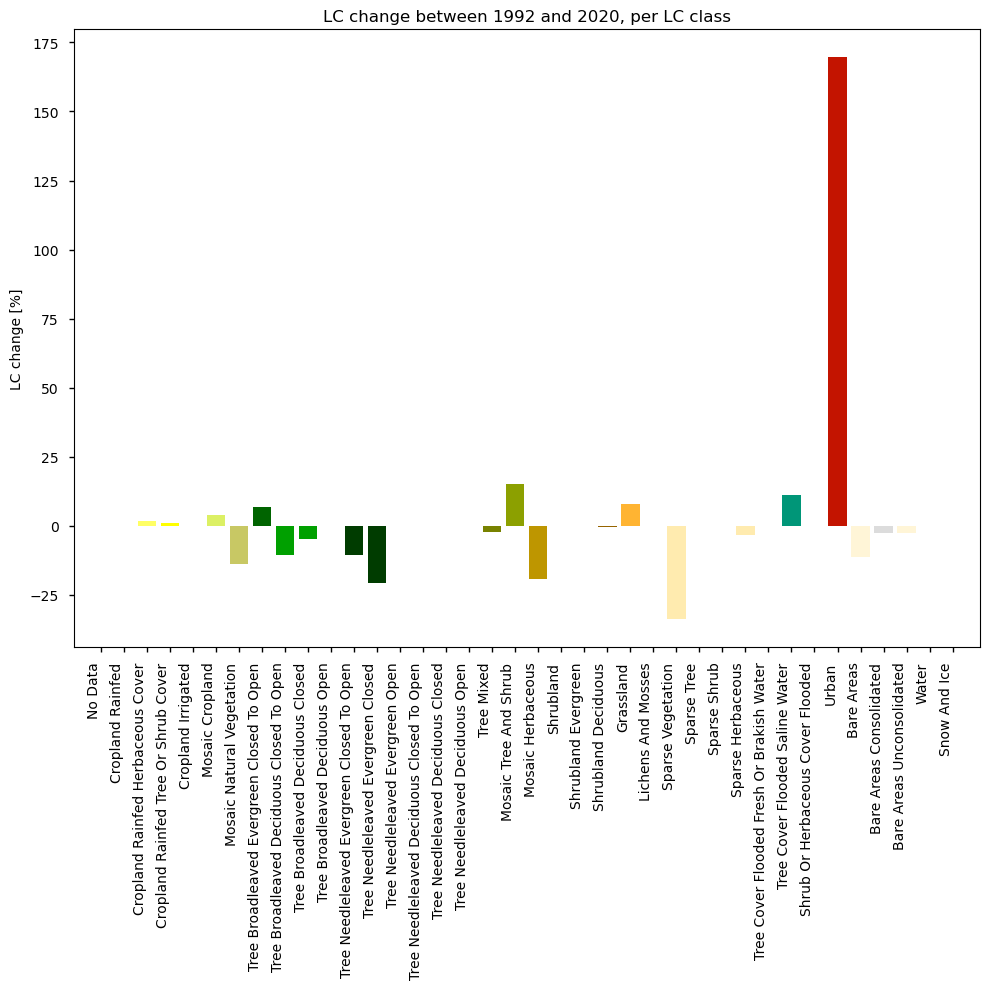

In [15]:
# Generate bar-chart with LC class change percentages in each year
keys = list(lccs_dict.keys())

results_values = [item[-1] for item in updated_lccs_dict.values()]

# Move the colors two units forward to match the corresponding keys
bar_colors = [item[0] for item in updated_lccs_dict.values()]

# Create a bar chart with specified colors
plt.figure(figsize=(10, 10))
bars = plt.bar(keys, results_values, color=bar_colors)

# Customize the plot (if needed)
plt.title("LC change between 1992 and 2020, per LC class", fontsize=12)
# plt.xlabel("Keys", fontsize=14)
plt.ylabel("LC change [%]", fontsize=10)
plt.xticks(rotation=90, ha='right', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

From this plot, we can verify that the 'Urban' class has indeed changed the most between 1992 and 2020 - in this AoI, 'Urban' areas have increased by more than 150%! By contrast, several vegetation classes have been reduced, although with percentages more evenly distributed accross different classes (e.g., broadleaved and needleleaved tree cover classes). 

## 4. Calculate the area percentage for the most populated regions
### Bar Charts - NUTS2

Having found the 'urbanization' pattern in this AoI, we can now look into specific NUTS 2 regions, in more detail. In particular, we will select those that include the greatest Iberian cities, in terms of population number. These statistics are retrieved from the Urban Audit Indicators database available at  European Commission - Eurostat (https://ec.europa.eu/eurostat/web/main/data).
The selected NUTS 2 regions are:

- Comunidad de Madrid, which includes the city of Madrid (5 098 717 people, in 2020), capital of Spain;
- Cataluña, which includes the city of Barcelona (3 755 512 people, in 2020);
- Área Metropolitana de Lisboa, which includes Lisboa (1 872 036 people, in 2020), capital of Portugal;
- Comunitat Valenciana, which includes Valencia (1 417 464 people, in 2020);
- Norte, which includes Porto (955 864 people, in 2020).

We will look at each one both in terms of area and percentages of total area, now using the IPCC classes to highlight the more aggregated LC changes. Please note that, in this case, the percentages depict the ratio of each class, in terms of area, from the total area of the corresponding NUT 2 - this is to facilitate the comparison across NUTS 2 with large area differences.

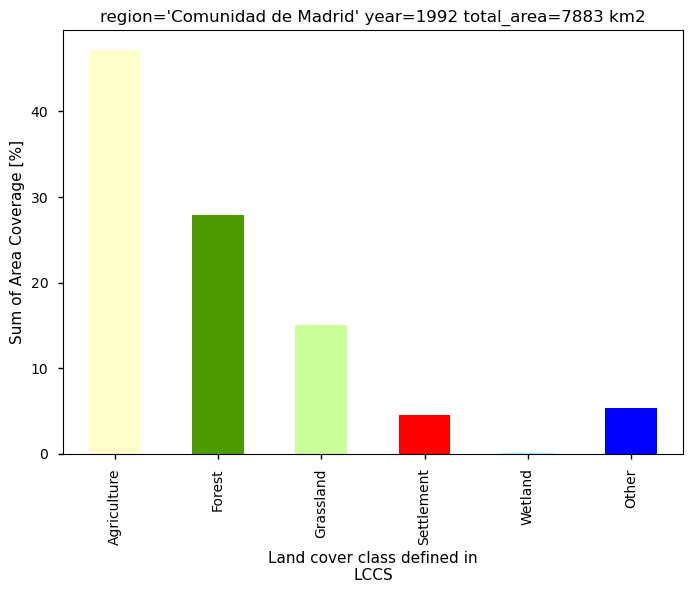

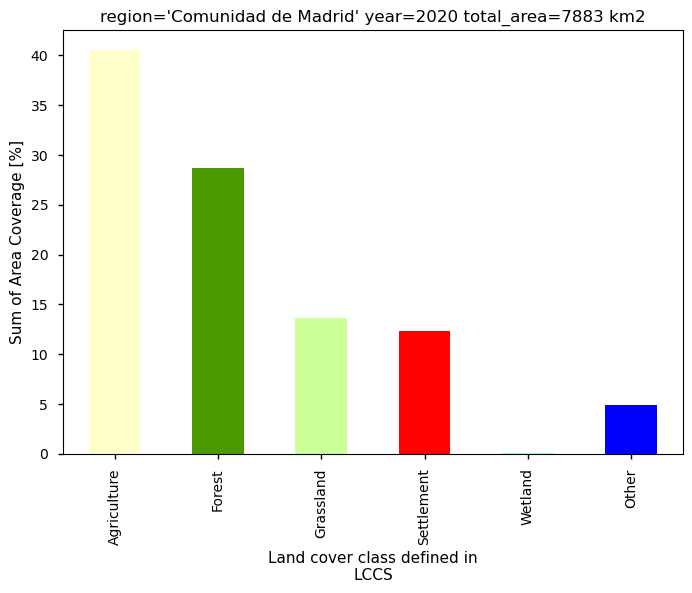

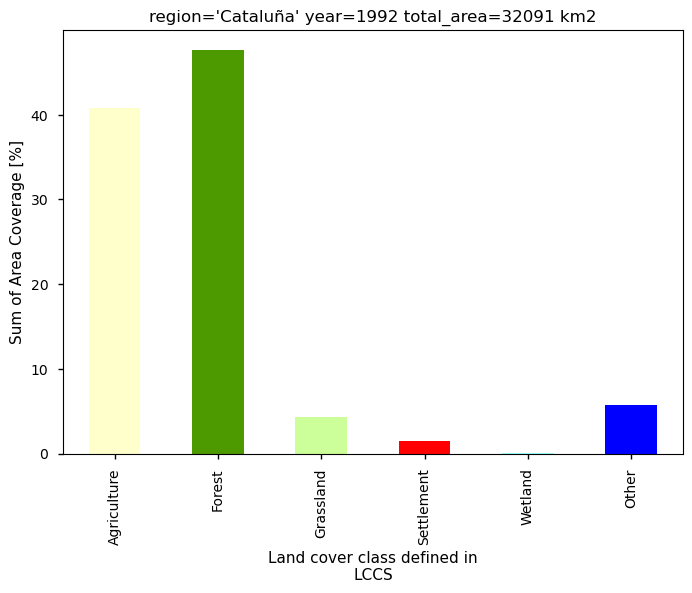

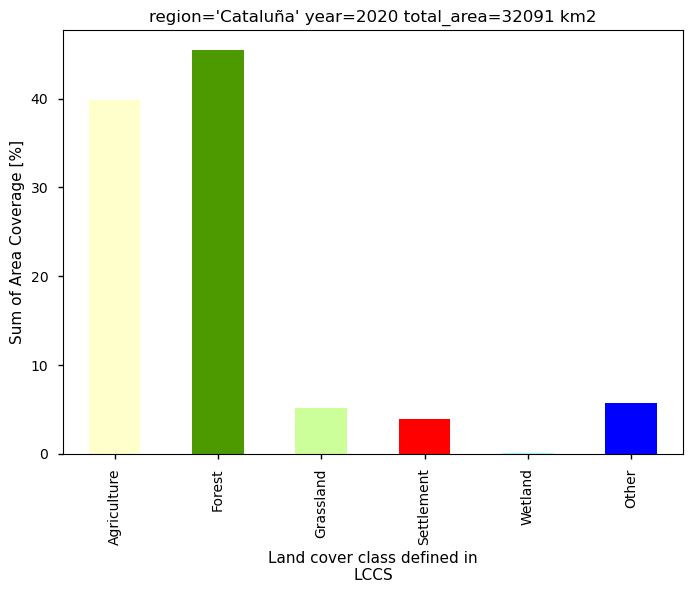

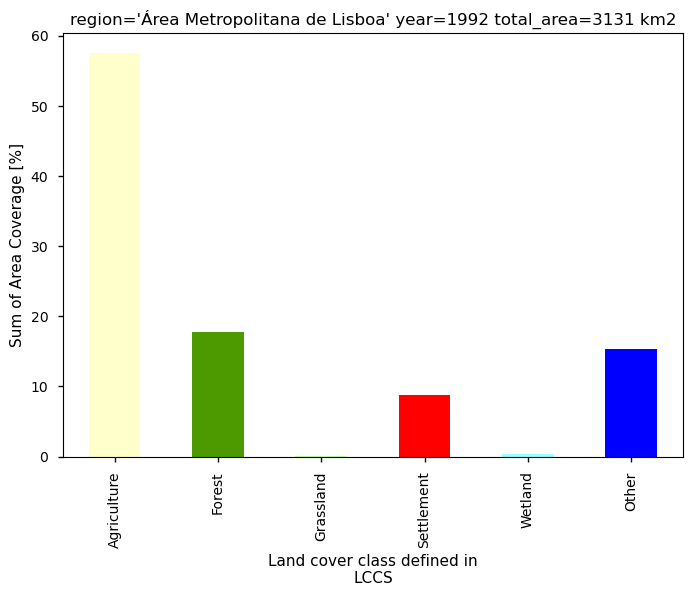

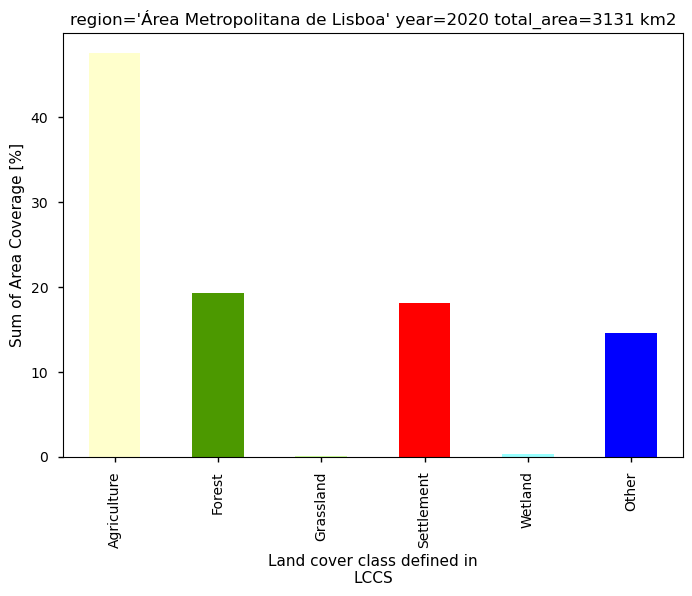

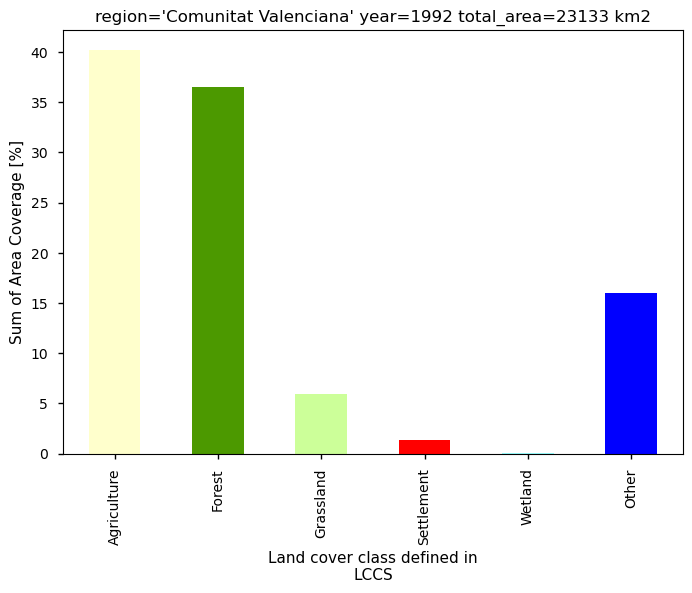

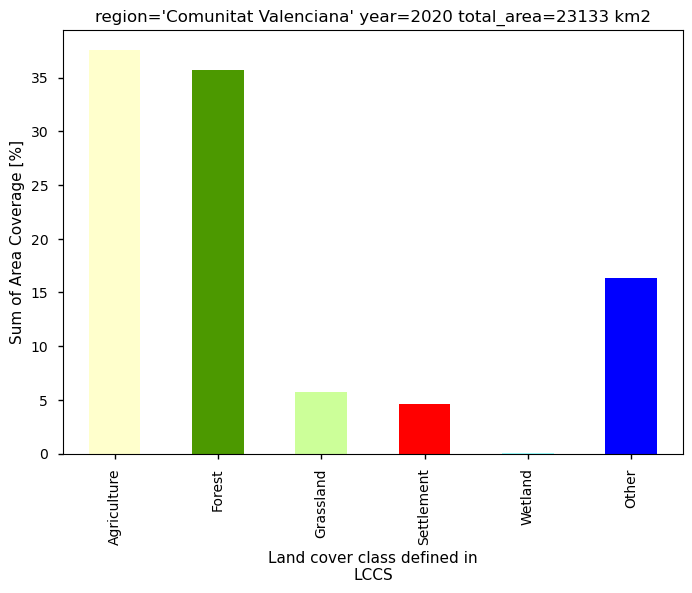

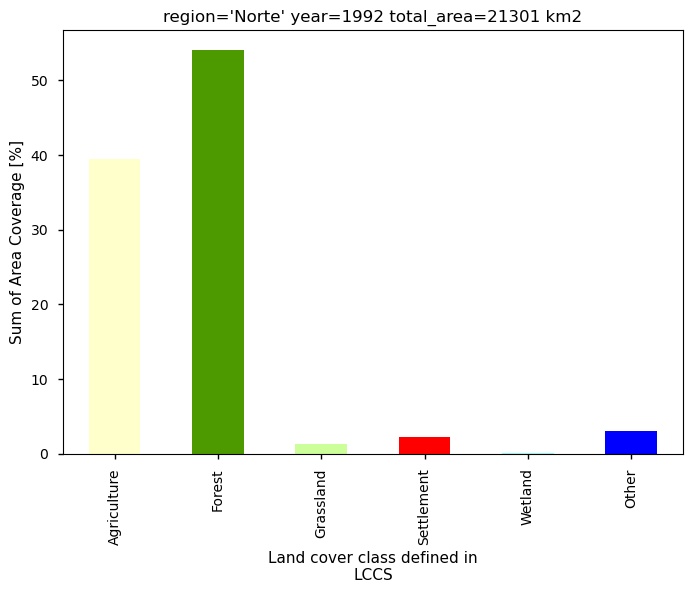

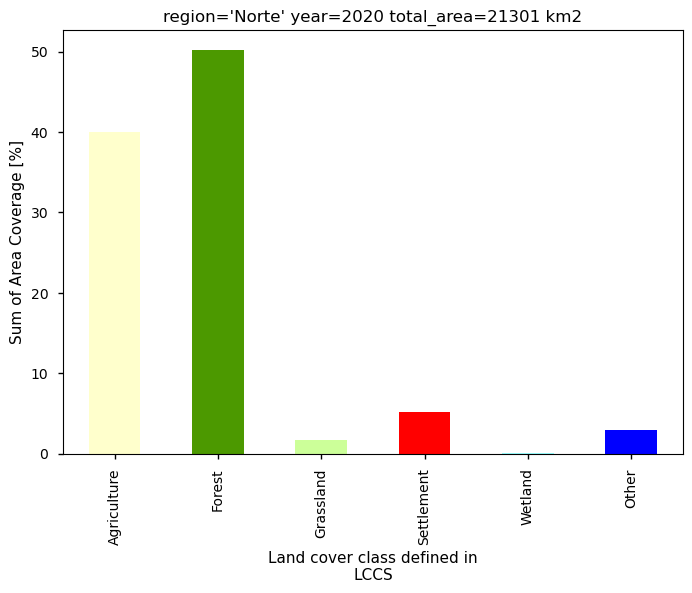

In [18]:
# Inspect, with generalize IPCC classes, the changes between years in specific regions (????) should we print the regions names prior to this cell
# Replace 'desired_region_name' with the name of the region you want to plot
regions_list = ["Comunidad de Madrid", "Cataluña", "Área Metropolitana de Lisboa", "Comunitat Valenciana", "Norte"]

for desired_region_name in regions_list:


    for index, ds_region in ds.groupby(mask):
        region = regions[int(index)].name

        # Add a condition to filter data for the desired region
        if region == desired_region_name:
            area = ds_region["cell_area"]
            total_area = int(area.sum().values)
            area_perc = 100 * area / total_area
            area_perc.attrs = {
                "long_name": "Area Coverage",
                "units": "%",
            }
            
        
            for labels_dict in [ipcc_dict]:
                for year, ds_year_region in ds_region.groupby("year"):
                    for da in [area_perc]:
                        plot.lccs_bar(
                            da,
                            ds_year_region["lccs_class"],
                            labels_dict,
                            reduction="sum",
                            title=f"{region=} {year=} {total_area=} {area.attrs['units']}",
                        )
                        plt.show()
        


From these plots we can see by how much these regions have been 'urbanized', in terms of LC change. In 1992, the IPCC 'Settlement' class (which corresponds the the 'Urban' class in the LC data) accounts for a minority of these NUTS 2 territories, with percentages ranging from circa 2% (Comunitat Valenciana) to 10% (Área Metropolitana de Lisboa). However, in 2020, this fraction has, at least, doubled in all of cases, with corresponding losses to the Agriculture and Grassland areas (except in Norte, where the Settlement's area increase is equivalent to the Forest's area reduction). This shows how these territories have become urbanized while loosing some percentage of produtive land. Nonetheless, Settlements still occupy 20% or less of the total area of these regions, and the Forest class does not show major differences, in most cases.

## 6. References:


1. Eurostat Nomenclature of territorial units for statistics regions and definition (NUTS) - https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts
    
2. Land Cover dataset Product User Guide (PUG) - https://datastore.copernicus-climate.eu/documents/satellite-land-cover/D5.3.1_PUGS_ICDR_LC_v2.1.x_PRODUCTS_v1.1.pdf

3. Eurostat, Data Browser - https://ec.europa.eu/eurostat/databrowser/explore/all/all_themes

4. Eurostat, Statistical Atlas - https://ec.europa.eu/statistical-atlas/viewer/?ch=gridvizChapter&mids=BKGCNT,totalPop21,CNTOVL&o=1,1,0.7&center=40.94812,-2.2287,5&lcis=totalPop21&

5. Fernández-Nogueira, D., & Corbelle-Rico, E. (2018). Land use changes in Iberian Peninsula 1990–2012. Land, 7(3), 99. https://doi.org/10.3390/land7030099

6. Feranec, J., Jaffrain, G., Soukup, T., & Hazeu, G. (2010). Determining changes and flows in European landscapes 1990–2000 using CORINE land cover data. Applied geography, 30(1), 19-35. https://doi.org/10.1016/j.apgeog.2009.07.003
    